In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
from matplotlib import pyplot as plt
from random import randint
import pandas as pd
import pickle

#### Get the data

In [2]:
datafolder = '../data/manual-clusters/20220430/categorized_new/'

newlabels = []

for label in os.listdir(datafolder):
    for image in os.listdir(datafolder + label):
        newlabels.append({
            'filename': datafolder + label + "/" + image,
            'class_id': label,
            
        })
        
newlabels = pd.DataFrame(newlabels)
newlabels.replace({"class_id":{"01":"01", "02-round-end":"02","03-mib":"03","04":"04","05-hole-flat":"05",
                               "06":"06","07-honeycomb":"07","08":"08","09":"09","10-honeycombhollow":"10",
                               "11-longthin":"11"}}, inplace=True)

implants = newlabels['filename']

#### Feature Extraction

In [3]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [4]:
%%time
data = {}
p = r"./KMeans-features"

# lop through each image in the dataset
for i in implants:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(i,model)
        data[i] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

Wall time: 5min 46s


#### PCA and KMeans

In [5]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=2, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [6]:
# cluster feature vectors
kmeans = KMeans(n_clusters=11, random_state=1)
label = kmeans.fit_predict(x)
newlabels['predicted_id'] = kmeans.labels_

C:\Users\zongy\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


#### Example images in some of the clusters

In [7]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

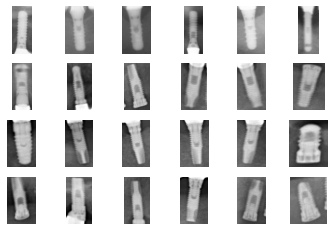

In [8]:
## show some example clusters
for num, i in enumerate(groups[2][:24]):
    img = load_img(i)
    plt.subplot(4,6,num+1)
    plt.axis('off')
    plt.imshow(img)

#### True label clustering visualization
Notice that category 04 can be somewhat better distinguished from others

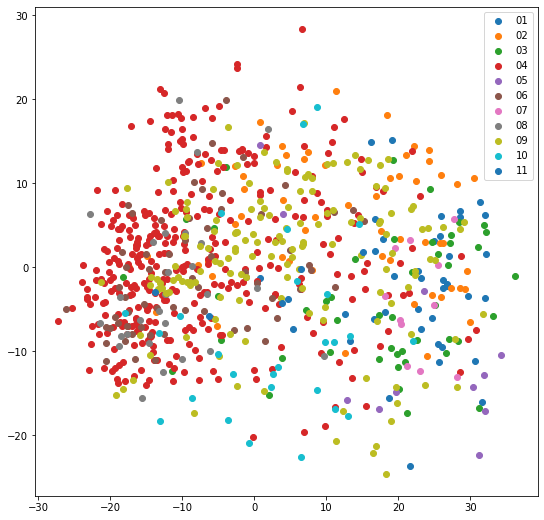

In [9]:
df = PCA(2).fit_transform(feat)
df.shape

#Getting unique labels
true_labels = newlabels['class_id'] 
u_labels = ["01","02","03","04","05","06","07","08","09","10","11"]
 
#plotting the results:
plt.figure(figsize=(9,9))
for i in u_labels:
    plt.scatter(df[true_labels == i , 0] , df[true_labels == i , 1] , label = i)
plt.legend()
plt.show()

#### KMeans Clustered labels visualization

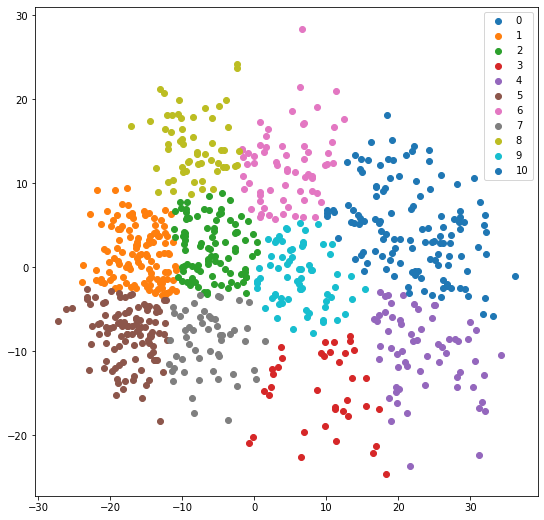

In [10]:
#Getting unique labels
 
u_labels = np.unique(kmeans.labels_)
 
#plotting the results:
plt.figure(figsize=(9,9))
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()